In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from collections import defaultdict


def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [2]:
df0 = pd.read_csv('complessivo_rms_finale.csv', index_col='id')
df1 = pd.read_csv('flat_df_no_nulli.csv', index_col=0)

### Multiclasse

In [3]:
#--------------------------------------- Codifico i generi
from sklearn.preprocessing import LabelEncoder

label_encoders = dict()
column2encode = ['ALBUM_type_']

for col in column2encode:
    le = LabelEncoder()
    df1[col] = le.fit_transform(df1[col])
    label_encoders[col] = le
    
df1 = df1[df1.TRACK_genre_top.isna() == False] #droppo i nulli

label_encoders = dict()
column2encode = ['TRACK_genre_top']

for col in column2encode:
    le = LabelEncoder()
    df1['TRACK_genre_top_num'] = le.fit_transform(df1[col])
    label_encoders[col] = le

    
df1['TRACK_genre_top_num']=[0 if genre == 3 else genre for genre in df1['TRACK_genre_top_num']]
df1['TRACK_genre_top_num']=[0 if genre == 0 else genre for genre in df1['TRACK_genre_top_num']]
df1['TRACK_genre_top_num']=[0 if genre == 14 else genre for genre in df1['TRACK_genre_top_num']]
df1['TRACK_genre_top_num']=[0 if genre == 2 else genre for genre in df1['TRACK_genre_top_num']]

df1['TRACK_genre_top_num']=[0 if genre == 15 else genre for genre in df1['TRACK_genre_top_num']]
df1['TRACK_genre_top_num']=[0 if genre == 11 else genre for genre in df1['TRACK_genre_top_num']]
df1['TRACK_genre_top_num']=[0 if genre == 10 else genre for genre in df1['TRACK_genre_top_num']]

df1['TRACK_genre_top_num']=[3 if genre == 13 else genre for genre in df1['TRACK_genre_top_num']] #rock 13 --> 3
df1['TRACK_genre_top_num']=[2 if genre == 12 else genre for genre in df1['TRACK_genre_top_num']] #pop 12 --> 2

### Binario

In [4]:
df = pd.merge(df1.TRACK_genre_top_num, df0, left_index=True, right_index=True)

#per la ram
df0 = None
df1  =None

df

TRACK_genre_top_num         0         1         2         3         4  \
2                         7  0.005965  0.030530  0.038409  0.052510  0.081335   
3                         7  0.009710  0.088201  0.120011  0.128533  0.150989   
5                         7  0.004292  0.036312  0.051975  0.046670  0.203390   
10                        2  0.110271  0.142744  0.156790  0.131847  0.125279   
134                       7  0.030768  0.152135  0.199774  0.269876  0.375679   
...                     ...       ...       ...       ...       ...       ...   
155315                    3  0.158557  0.158167  0.145906  0.162589  0.188191   
155316                    3  0.127192  0.209792  0.245813  0.218415  0.202730   
155317                    3  0.124034  0.126594  0.129472  0.126551  0.120213   
155318                    3  0.106511  0.103265  0.105738  0.119232  0.133367   
155319                    3  0.114174  0.109436  0.127783  0.124033  0.089186   

               5         6         7         8  ...      1282      1283  \
2       0.096664  0.092021  0.083451  0.083296  ...  0.167174  0.126127   
3       0.169258  0.205793  0.261233  0.279276  ...  0.126499  0.103162   
5       0.283229  0.314644  0.322023  0.293859  ...  0.318426  0.312173   
10      0.129176  0.128395  0.171358  0.298087  ...  0.296138  0.217364   
134     0.391104  0.359060  0.326591  0.276587  ...  0.085308  0.058013   
...          ...       ...       ...       ...  ...       ...       ...   
155315  0.173111  0.155064  0.165688  0.173078  ...  0.026859  0.027577   
155316  0.186682  0.181166  0.170364  0.171622  ...  0.177781  0.196609   
155317  0.125967  0.148710  0.156304  0.137944  ...  0.068987  0.070163   
155318  0.139314  0.132606  0.124244  0.125047  ...  0.205924  0.127026   
155319  0.107159  0.125980  0.124494  0.129173  ...  0.078126  0.083256   

            1284      1285      1286      1287      1288      1289      1290  \
2       0.111858  0.095006  0.099327  0.097803  0.107587  0.152822  0.177150   
3       0.147984  0.207548  0.256682  0.254089  0.194205  0.146202  0.119663   
5       0.305558  0.281919  0.234308  0.178978  0.163058  0.143980  0.120217   
10      0.184314  0.176318  0.161866  0.158079  0.158619  0.148111  0.146005   
134     0.057826  0.070345  0.089812  0.085378  0.086922  0.105205  0.105316   
...          ...       ...       ...       ...       ...       ...       ...   
155315  0.024202  0.023801  0.025244  0.025122  0.021450  0.018870  0.017375   
155316  0.196542  0.175911  0.152180  0.142664  0.140520  0.136186  0.171844   
155317  0.073941  0.072122  0.074395  0.076910  0.077558  0.078151  0.076024   
155318  0.125577  0.114014  0.104968  0.097456  0.094659  0.112066  0.122239   
155319  0.077798  0.070611  0.071213  0.073995  0.073004  0.075254  0.081455   

            1291  
2       0.000000  
3       0.121850  
5       0.107188  
10      0.000000  
134     0.090875  
...          ...  
155315  0.018515  
155316  0.185346  
155317  0.077503  
155318  0.115811  
155319  0.069464  

[49229 rows x 1293 columns]

In [5]:
#Ho 1292 sample estratti facendo la media ogni 512 posizioni di 1024 valori.
#I sample originali erano 22050*30s
#Ogni sample estratto rappresenta 23.22 ms di canzone
#Con shapelet lunghe 44 rappresento 1,02s di canzone, di conseguenza definisco:

LEN_S = list()

for i in range(30):
    LEN_S.append(44*i)

#Si usa mettendo nelle [] il numero di secondi
LEN_S[2]

88

In [6]:
class_name = 'TRACK_genre_top_num'

X = df.drop(columns=["TRACK_genre_top_num"]).values
y = df[class_name]

scaler = TimeSeriesScalerMeanVariance(mu=0, std=1.)
X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

#scaler = TimeSeriesScalerMinMax()
#X = scaler.fit_transform(X).reshape(X.shape[0], X.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100, stratify=y)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1091, 1: 1091, 2: 1091, 3: 1091, 4: 1091, 5: 1091, 6: 1091, 7: 1091, 8: 1091, 9: 1091})


In [7]:
from keras.optimizers import Adagrad
from tslearn.shapelets import LearningShapelets
from tslearn.shapelets import grabocka_params_to_shapelet_size_dict

C:\Users\cri98\anaconda3\lib\site-packages\tslearn\clustering\kmeans.py:16: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  warnings.warn(


In [8]:
n_ts, ts_sz = X.shape
n_classes = len(set(y))

# Set the number of shapelets per size as done in the original paper
shapelet_sizes = grabocka_params_to_shapelet_size_dict(n_ts=n_ts,
                                                       ts_sz=ts_sz,
                                                       n_classes=n_classes,
                                                       l=1/30, #1s
                                                       r=1)

print('n_ts', n_ts)
print('ts_sz', ts_sz)
print('n_classes', n_classes)
print('shapelet_sizes', shapelet_sizes)

n_ts 49229
ts_sz 1292
n_classes 10
shapelet_sizes {43: 8}


def prova(reg):
    print(reg)
    shp_clf = ShapeletModel(n_shapelets_per_size=shapelet_sizes,
                            optimizer="AdaDelta",
                            weight_regularizer=reg,
                            max_iter=50, #.01 f .86 <--> .025 t .82
                            scale = True,
                            verbose=1)

    shp_clf.fit(X_res, y_res)
    
    y_pred = shp_clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

#result = {}
for i in range(30, 30+1, 5):
    result[i/1000.0] = prova(i/1000.0)

result

In [9]:
result

NameError: name 'result' is not defined

In [ ]:
result

In [ ]:
result

In [10]:
shp_clf = LearningShapelets(n_shapelets_per_size={25: 60, 44: 30, 88: 15},
                            optimizer="sgd",
                            weight_regularizer=.01,
                            max_iter=50,
                            verbose=1)

shp_clf.fit(X_res, y_res)
#shp_clf.fit(X_test, y_test)

y_pred = shp_clf.predict(X_test)

C:\Users\cri98\anaconda3\lib\site-packages\tslearn\shapelets\shapelets.py:354: FutureWarning: The default value for 'scale' is set to False in version 0.4 to ensure backward compatibility, but is likely to change in a future version.
  warnings.warn("The default value for 'scale' is set to False "


Epoch 1/50
43/43 [==============================] - 5s 41ms/step - loss: 3.0613 - categorical_accuracy: 0.1091 - categorical_crossentropy: 2.8823
Epoch 2/50
43/43 [==============================] - 2s 41ms/step - loss: 2.4883 - categorical_accuracy: 0.1049 - categorical_crossentropy: 2.3132
Epoch 3/50
43/43 [==============================] - 2s 40ms/step - loss: 2.4748 - categorical_accuracy: 0.1144 - categorical_crossentropy: 2.3029
Epoch 4/50
43/43 [==============================] - 2s 40ms/step - loss: 2.4590 - categorical_accuracy: 0.1301 - categorical_crossentropy: 2.2901
Epoch 5/50
43/43 [==============================] - 2s 40ms/step - loss: 2.4479 - categorical_accuracy: 0.1328 - categorical_crossentropy: 2.2819
Epoch 6/50
43/43 [==============================] - 2s 40ms/step - loss: 2.4379 - categorical_accuracy: 0.1386 - categorical_crossentropy: 2.2748
Epoch 7/50
43/43 [==============================] - 2s 40ms/step - loss: 2.4312 - categorical_accuracy: 0.1469 - categorical

In [11]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.23055047735120862
F1-score [0.08843537 0.14285714 0.05405405 0.43963554 0.11009174 0.17517136
 0.17555556 0.25623736 0.00847458 0.03747073]
              precision    recall  f1-score   support

           0       0.14      0.06      0.09       203
           1       0.08      0.63      0.14       121
           2       0.12      0.03      0.05       232
           3       0.47      0.41      0.44      1415
           4       0.24      0.07      0.11       925
           5       0.44      0.11      0.18      1054
           6       0.13      0.29      0.18       277
           7       0.17      0.54      0.26       353
           8       0.03      0.00      0.01       207
           9       0.03      0.06      0.04       136

    accuracy                           0.23      4923
   macro avg       0.19      0.22      0.15      4923
weighted avg       0.31      0.23      0.22      4923



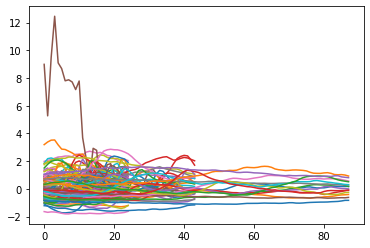

In [12]:
for i in shp_clf.shapelets_:
    plt.plot(i)

In [13]:
type(shp_clf.shapelets_)

numpy.ndarray

In [14]:
shp_clf.shapelets_[0].shape

(25, 1)

In [15]:
np.save("shapelet.shp", shp_clf.shapelets_)

In [16]:
from sklearn.metrics import accuracy_score

predicted_labels = shp_clf.predict(X)
predicted_locations = shp_clf.locate(X)
print("Correct classification rate:", accuracy_score(y, predicted_labels))

193/193 [==============================] - 4s 18ms/step
Correct classification rate: 0.23033171504600947


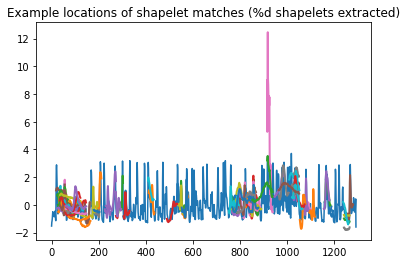

In [17]:
ts_id = 0
plt.figure()
n_shapelets = sum(shapelet_sizes.values())
plt.title("Example locations of shapelet matches "
          "(%d shapelets extracted)".format(n_shapelets))

plt.plot(X[ts_id].ravel())
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)

0


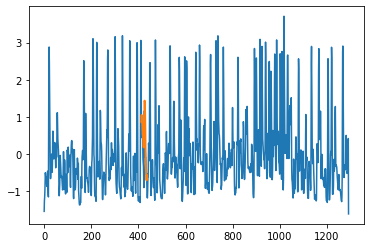

1


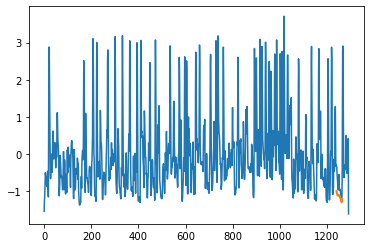

2


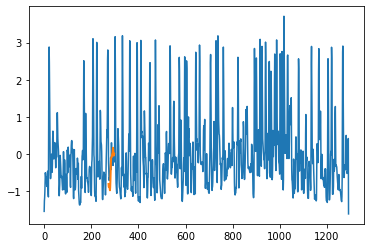

3


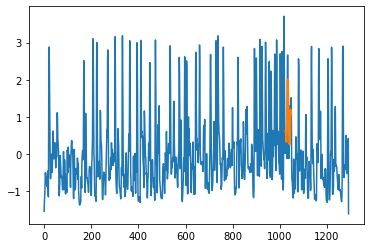

4


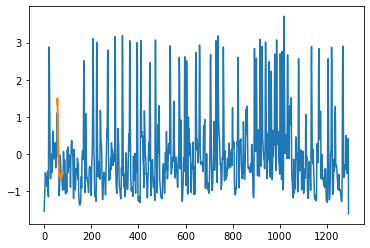

5


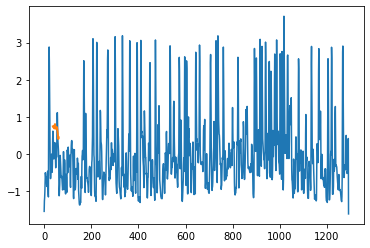

6


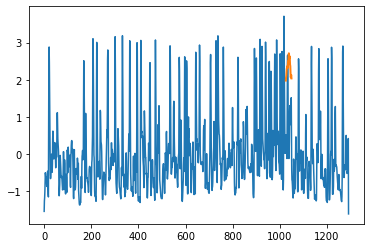

7


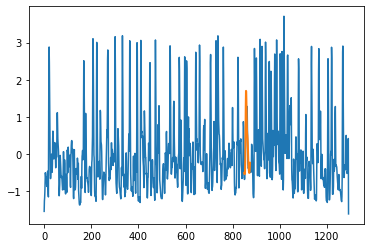

8


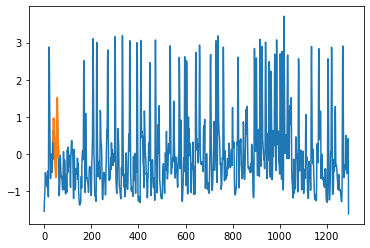

9


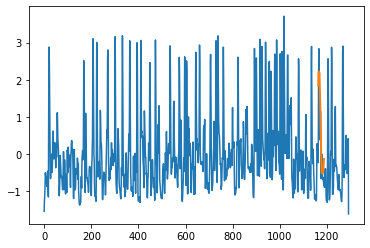

10


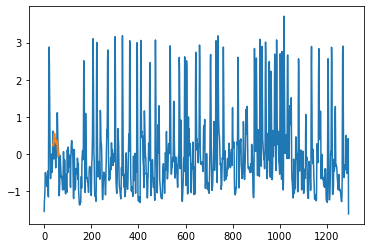

11


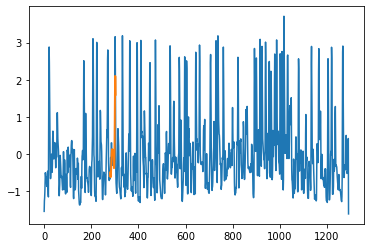

12


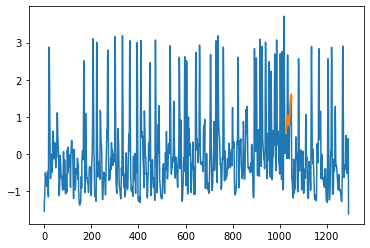

13


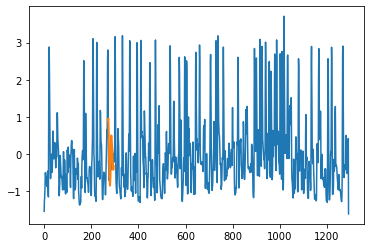

14


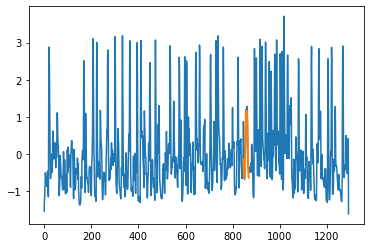

15


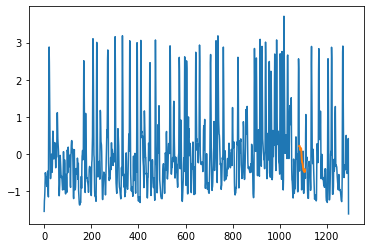

16


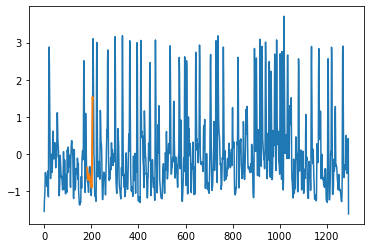

17


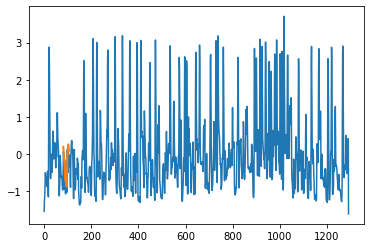

18


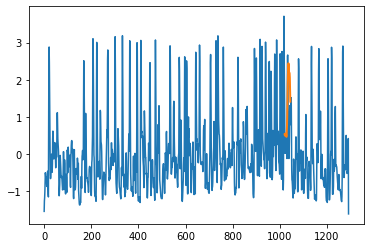

19


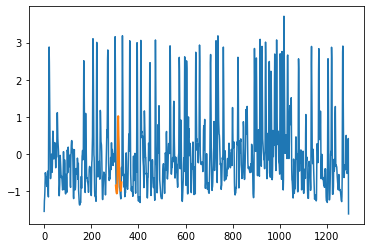

20


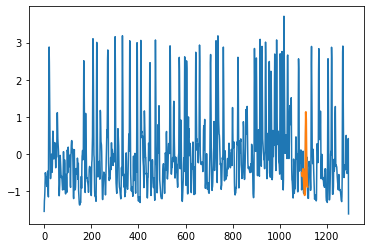

21


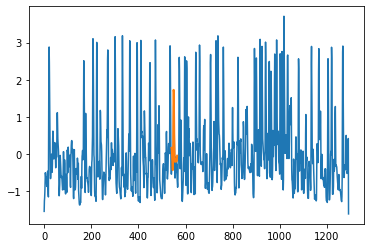

22


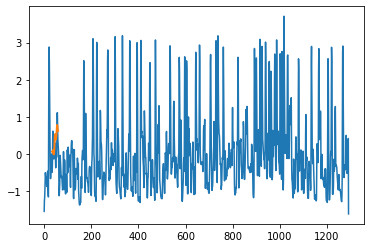

23


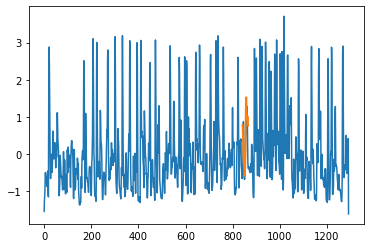

24


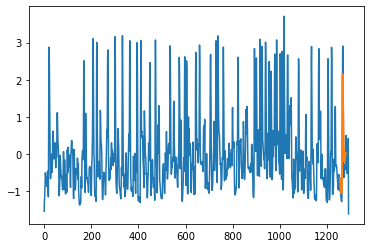

25


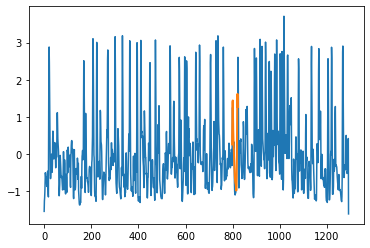

26


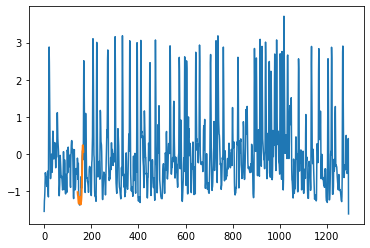

27


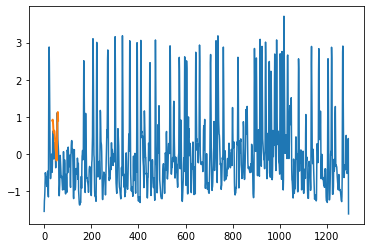

28


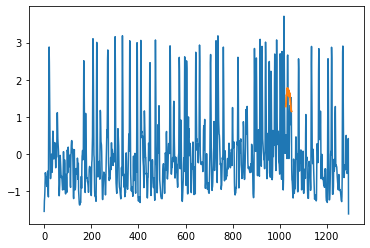

29


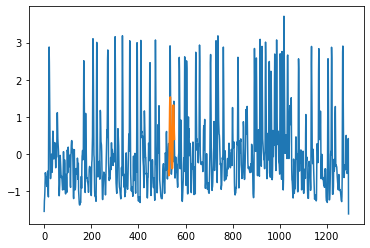

30


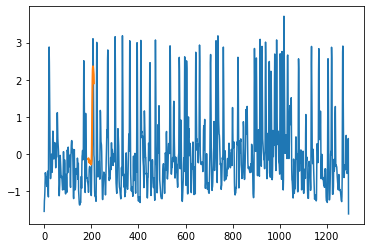

31


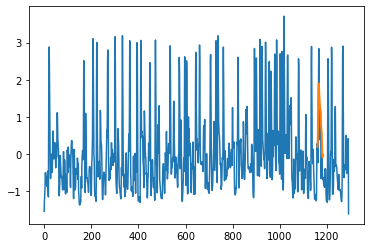

32


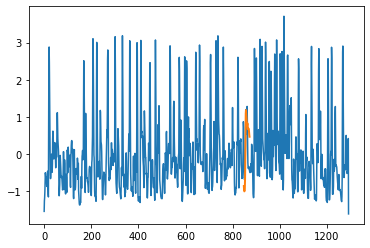

33


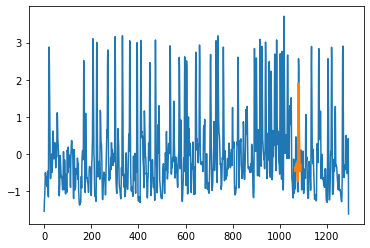

34


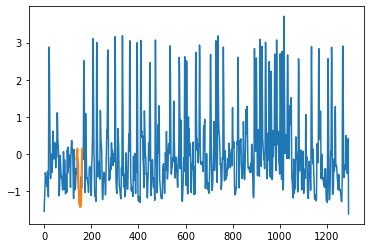

35


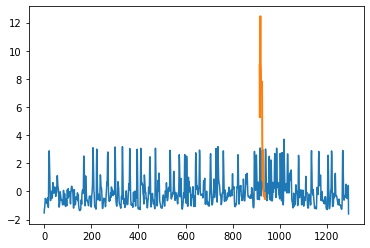

36


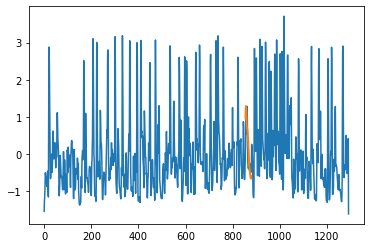

37


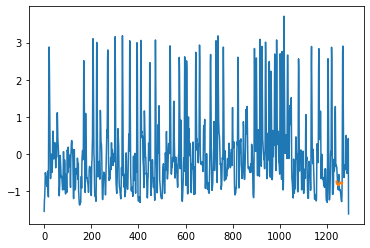

38


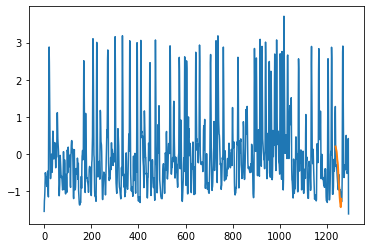

39


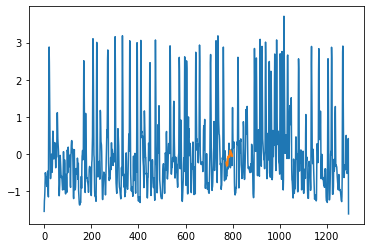

40


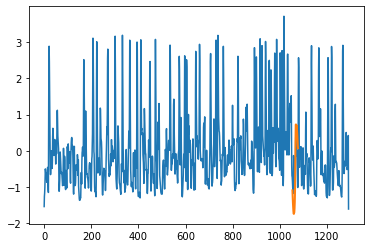

41


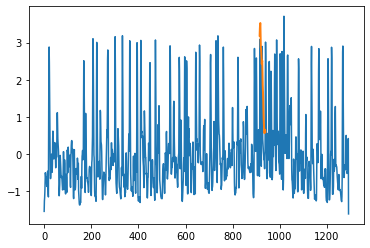

42


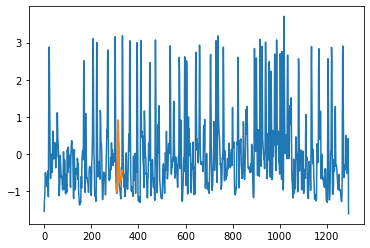

43


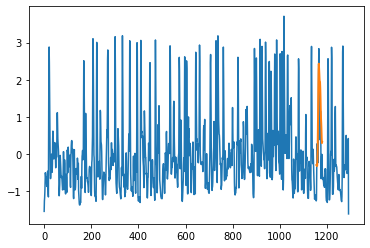

44


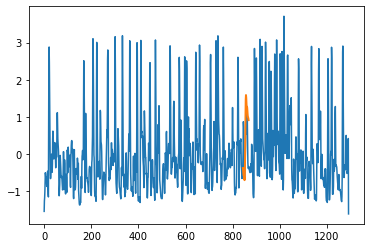

45


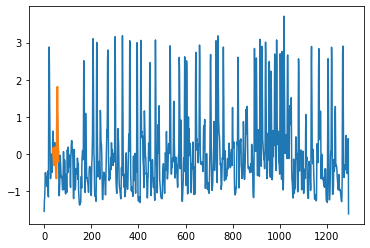

46


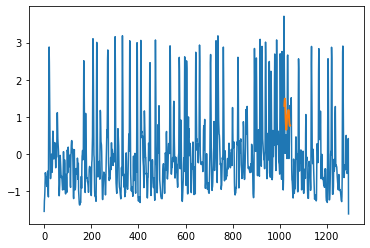

47


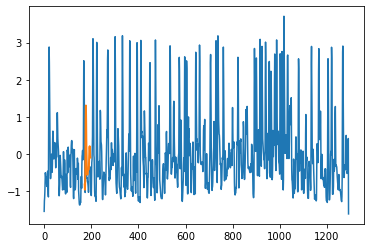

48


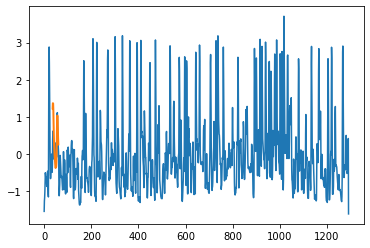

49


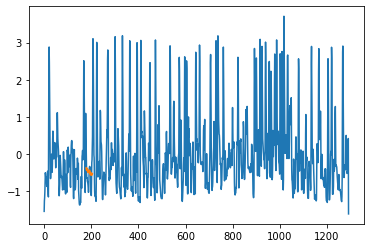

50


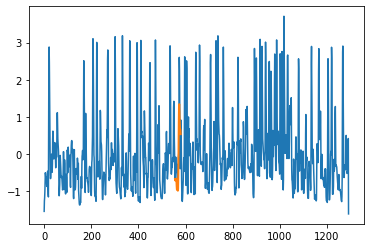

51


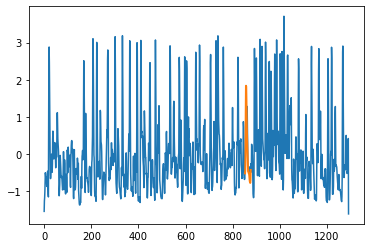

52


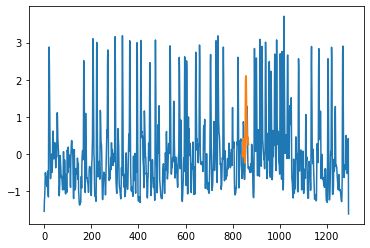

53


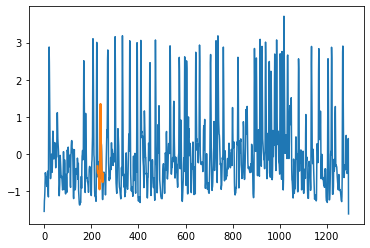

54


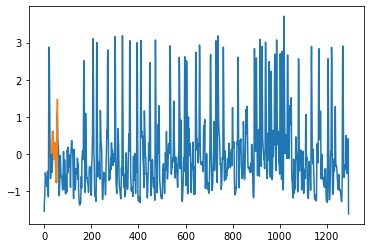

55


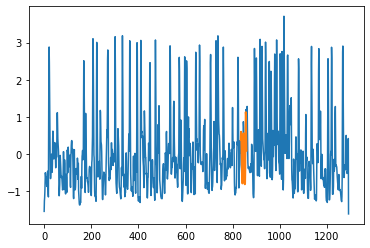

56


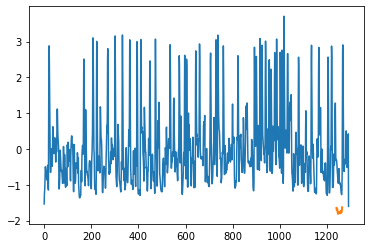

57


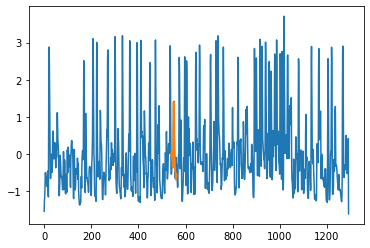

58


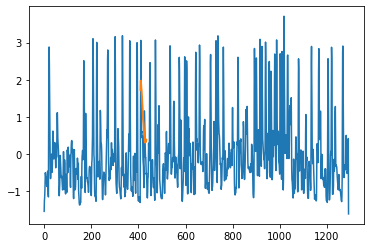

59


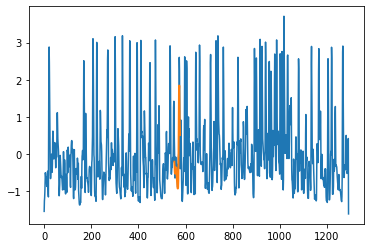

60


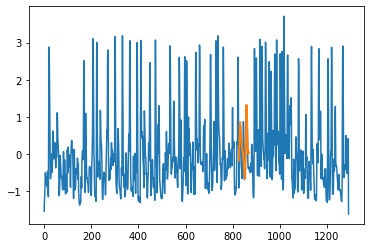

61


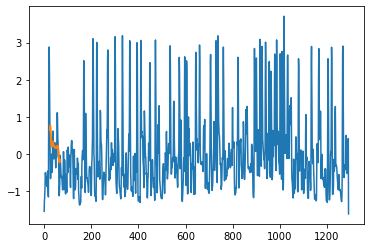

62


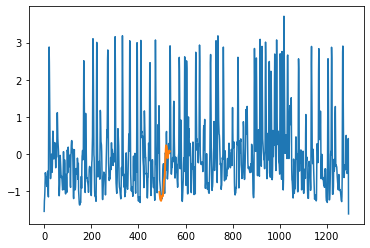

63


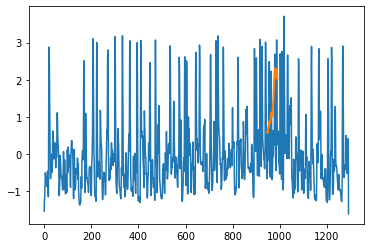

64


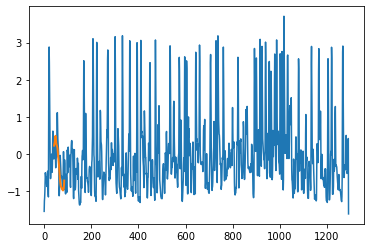

65


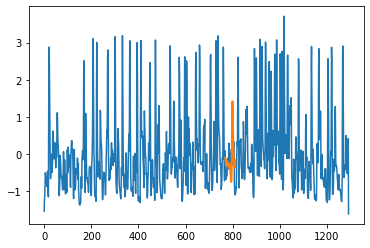

66


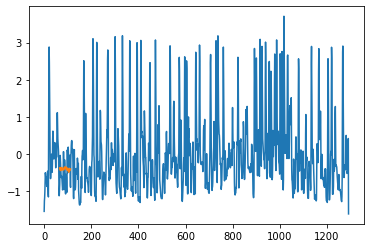

67


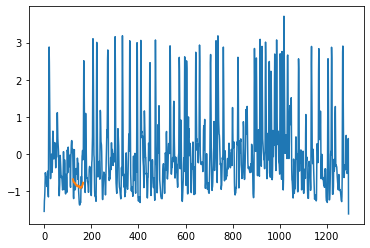

68


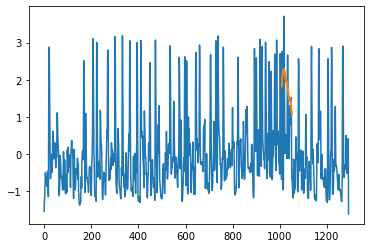

69


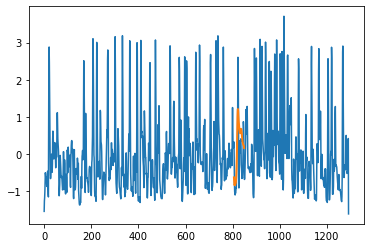

70


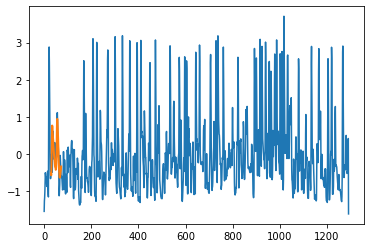

71


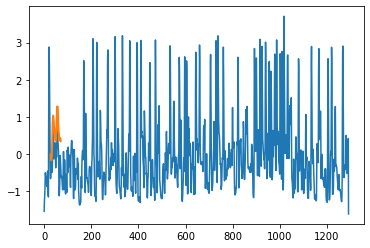

72


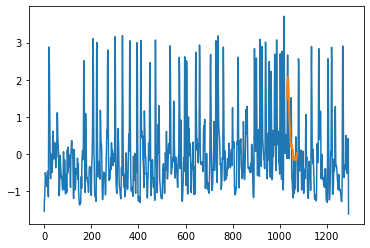

73


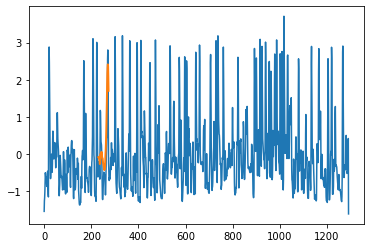

74


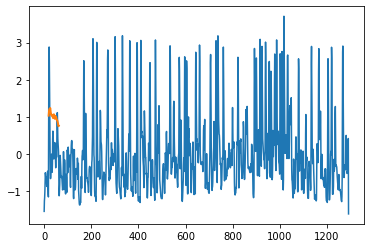

75


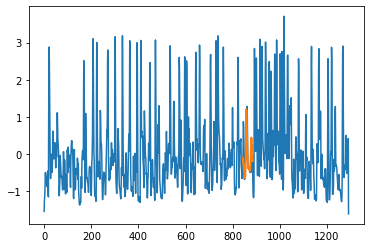

76


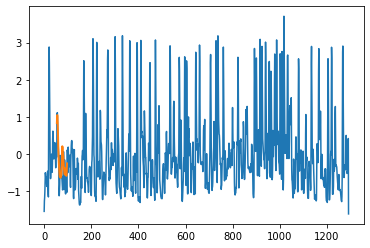

77


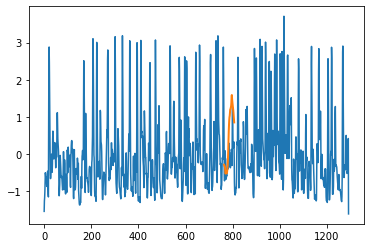

78


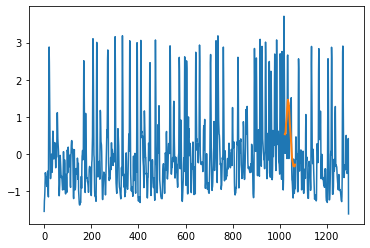

79


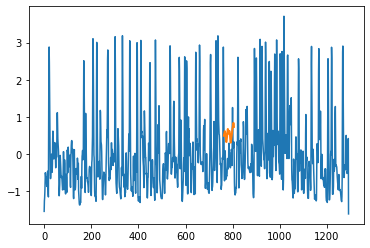

80


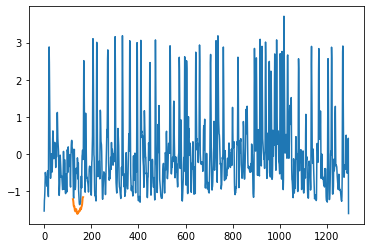

81


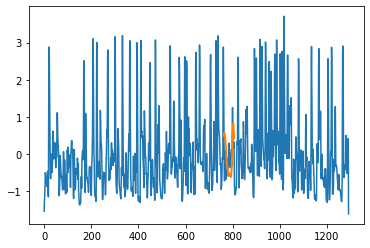

82


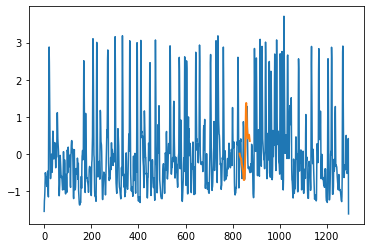

83


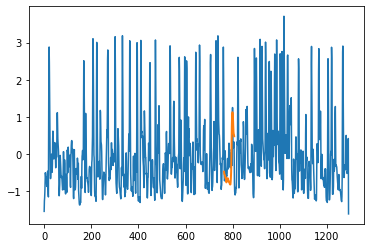

84


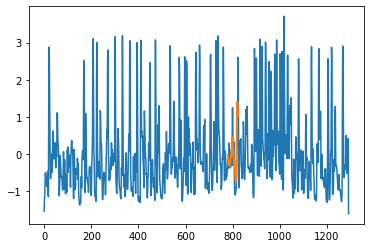

85


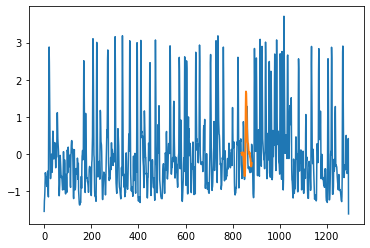

86


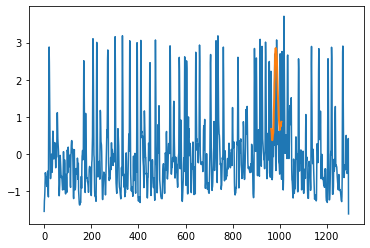

87


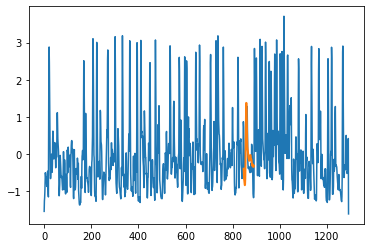

88


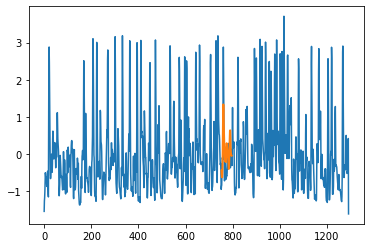

89


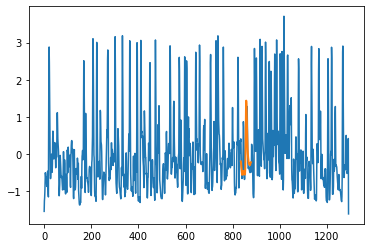

90


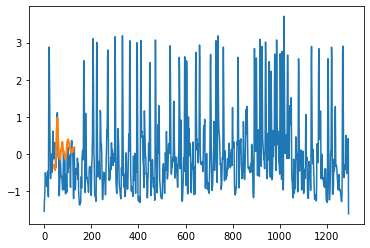

91


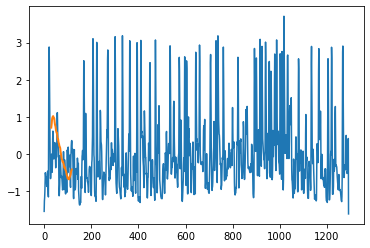

92


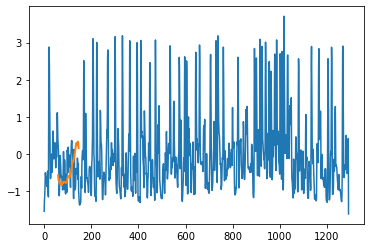

93


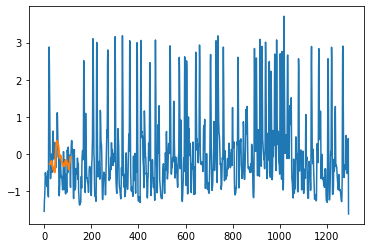

94


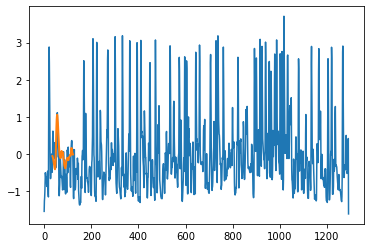

95


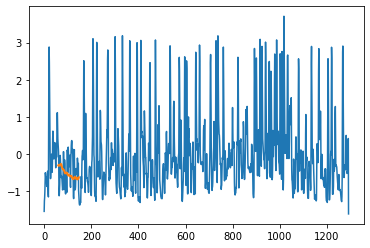

96


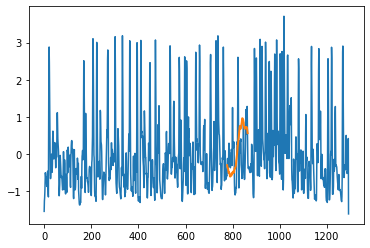

97


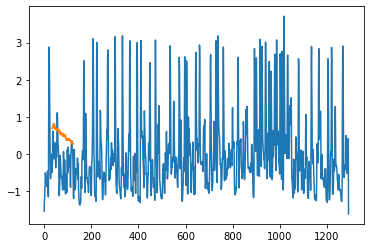

98


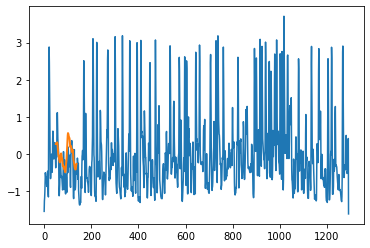

99


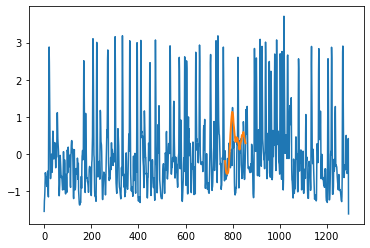

100


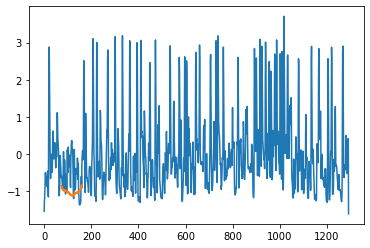

101


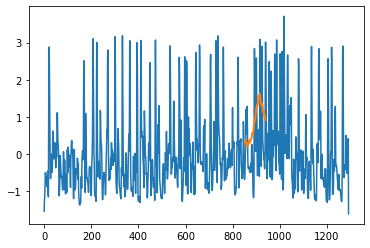

102


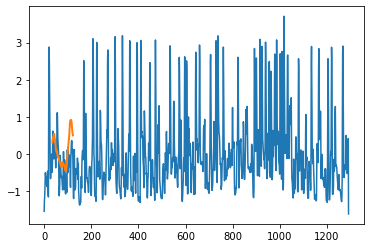

103


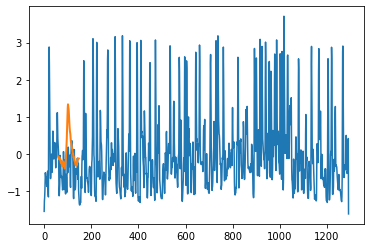

104


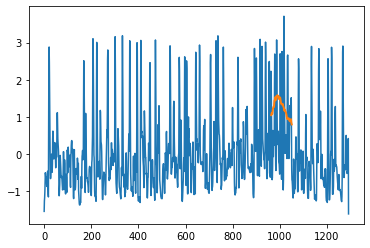

In [18]:
for idx_shp, shp in enumerate(shp_clf.shapelets_):
    plt.plot(X[ts_id].ravel())
    t0 = predicted_locations[ts_id, idx_shp]
    plt.plot(np.arange(t0, t0 + len(shp)), shp, linewidth=2)
    print(idx_shp)
    plt.show()

In [19]:
#plt.plot(X[ts_id].ravel())
t0 = predicted_locations[ts_id, idx_shp]
t0

963

In [20]:
import librosa


path = "C:/Users/cri98/Downloads/fma_large/000804.mp3"

y, sr = librosa.load(path, sr=22050, mono=True)

idx_shape = 95

shp = shp_clf.shapelets_[idx_shape]

start = (predicted_locations[ts_id, idx_shp])*512

stop = (predicted_locations[ts_id, idx_shp] + len(shp))*512

print(len(shp)/44, "s")

ipd.Audio(y[start:stop], rate=sr)

C:\Users\cri98\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/cri98/Downloads/fma_large/000804.mp3'

In [ ]:
import librosa
import IPython.display as ipd


path = "C:/Users/cri98/Downloads/fma_large_/003691.mp3"
y, sr = librosa.load(path, sr=22050, mono=True)


motif_len = 44*1

start = (211)*512
stop = motif_len*512 + start

ipd.Audio(y[start:stop], rate=sr)

In [ ]:
start = (332)*512
stop = motif_len*512 + start

ipd.Audio(y[start:stop], rate=sr)

In [ ]:
y_, sr_ = librosa.load(path, sr=22050*4, mono=False)

ipd.Audio(y_, rate=sr_)

In [ ]:
plt.plot(y_)

# Shaplet-distances-based Classifier


## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train2 = shp_clf.transform(X_train)
X_res2 = shp_clf.transform(X_res)
X_test2 = shp_clf.transform(X_test)

X_train2.shape

In [20]:
param_grid = {'weights': ['distance'],#, 'uniform'],
              'n_neighbors': range(200, 2200 +1, 400), #range originale 1 --> 200 +1
              'p': [1]#, 2]
             }

clf = KNeighborsClassifier()


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train2, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  18 | elapsed:  2.2min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done   5 out of  18 | elapsed:  2.5min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:  2.6min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:  2.7min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done  11 out of  18 | elapsed:  2.8min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:  2.9min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:  2.9min remaining:   34.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  3.0min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(200, 2201, 400), 'p': [1],
                         'weights': ['distance']},
             scoring='accuracy', verbose=10)

In [21]:
#59 --> 400

report(grid_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.390 (std: 0.003)
Parameters: {'n_neighbors': 200, 'p': 1, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.379 (std: 0.003)
Parameters: {'n_neighbors': 600, 'p': 1, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.374 (std: 0.003)
Parameters: {'n_neighbors': 1000, 'p': 1, 'weights': 'distance'}

Model with rank: 4
Mean validation score: 0.371 (std: 0.003)
Parameters: {'n_neighbors': 1400, 'p': 1, 'weights': 'distance'}

Model with rank: 5
Mean validation score: 0.368 (std: 0.003)
Parameters: {'n_neighbors': 1800, 'p': 1, 'weights': 'distance'}



In [41]:
#clf = KNeighborsClassifier(n_neighbors=67, p=1, weights='distance') #migliore bilanciato (.257)

clf = KNeighborsClassifier(n_neighbors=59, p=1, weights='distance', n_jobs=-1) #migliore sbilanciato (.4)

clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


Accuracy 0.4044281941905342
F1-score [0.04739336 0.03174603 0.00840336 0.53667954 0.33879004 0.41220769
 0.07920792 0.34137291 0.03755869 0.06944444]
              precision    recall  f1-score   support

           0       0.62      0.02      0.05       203
           1       0.40      0.02      0.03       121
           2       0.17      0.00      0.01       232
           3       0.41      0.79      0.54      1415
           4       0.50      0.26      0.34       925
           5       0.35      0.49      0.41      1054
           6       0.46      0.04      0.08       277
           7       0.49      0.26      0.34       353
           8       0.67      0.02      0.04       207
           9       0.62      0.04      0.07       136

    accuracy                           0.40      4923
   macro avg       0.47      0.19      0.19      4923
weighted avg       0.44      0.40      0.34      4923



In [39]:
#clf = KNeighborsClassifier(n_neighbors=67, p=1, weights='distance') #migliore bilanciato (.257)

clf = KNeighborsClassifier(n_neighbors=59, p=1, weights='distance', n_jobs=-1) #migliore sbilanciato (.4)

clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.399553118017469
F1-score [0.0862069  0.10606061 0.04878049 0.54303639 0.2959707  0.40874233
 0.10084034 0.36363636 0.04694836 0.        ]
              precision    recall  f1-score   support

           0       0.34      0.05      0.09       203
           1       0.64      0.06      0.11       121
           2       0.43      0.03      0.05       232
           3       0.42      0.76      0.54      1415
           4       0.46      0.22      0.30       925
           5       0.34      0.51      0.41      1054
           6       0.23      0.06      0.10       277
           7       0.47      0.29      0.36       353
           8       0.83      0.02      0.05       207
           9       0.00      0.00      0.00       136

    accuracy                           0.40      4923
   macro avg       0.42      0.20      0.20      4923
weighted avg       0.41      0.40      0.34      4923



C:\Users\cri98\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [None] + [20], #range originale 4, 40+1, 4
              'min_samples_split': [2], #2, 150+1, 10
              'min_samples_leaf': [2], #2, 150+1, 10
              'class_weight': ['balanced']
             }

clf = DecisionTreeClassifier()


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=5)
grid_search.fit(X_train2, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    7.3s remaining:   41.8s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    7.4s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    7.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:   19.0s remaining:   12.6s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:   19.0s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:   19.3s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   19.7s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 20], 'min_samples_leaf': [2],
                         'min_samples_split': [2]},
             scoring='accuracy', verbose=10)

In [84]:
report(grid_search.cv_results_, n_top=5)

Model with rank: 1
Mean validation score: 0.250 (std: 0.003)
Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.249 (std: 0.010)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}

Model with rank: 3
Mean validation score: 0.248 (std: 0.002)
Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2}

Model with rank: 4
Mean validation score: 0.247 (std: 0.005)
Parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}



In [88]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=None, random_state=42, class_weight='balanced', criterion='entropy', min_samples_leaf=2, min_samples_split=2) #migliore sbilanciato .634

clf.fit(X_train2, y_train)

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.24436319317489336
F1-score [0.07002188 0.19305019 0.05769231 0.37644342 0.25718937 0.26126126
 0.13225806 0.23577236 0.09224319 0.05952381]
              precision    recall  f1-score   support

           0       0.06      0.08      0.07       203
           1       0.18      0.21      0.19       121
           2       0.05      0.06      0.06       232
           3       0.41      0.35      0.38      1415
           4       0.26      0.26      0.26       925
           5       0.28      0.25      0.26      1054
           6       0.12      0.15      0.13       277
           7       0.23      0.25      0.24       353
           8       0.08      0.11      0.09       207
           9       0.05      0.07      0.06       136

    accuracy                           0.24      4923
   macro avg       0.17      0.18      0.17      4923
weighted avg       0.26      0.24      0.25      4923



# Feature-based Classifier

In [21]:
import scipy.stats as stats

def calculate_features(values):
    features = {
        'avg': np.mean(values),
        'std': np.std(values),
        'var': np.var(values),
        'med': np.median(values),
        '10p': np.percentile(values, 10),
        '25p': np.percentile(values, 25),
        '50p': np.percentile(values, 50),
        '75p': np.percentile(values, 75),
        '90p': np.percentile(values, 90),
        'iqr': np.percentile(values, 75) - np.percentile(values, 25),
        #'cov': 1.0 * np.mean(values) / np.std(values),
        'skw': stats.skew(values),
        'kur': stats.kurtosis(values)
    }

    return features

X_train3 = np.array([list(calculate_features(x).values()) for x in X_train])
X_res3 = np.array([list(calculate_features(x).values()) for x in X_res])
X_test3 = np.array([list(calculate_features(x).values()) for x in X_test])

X_train3.shape

(44306, 12)

In [119]:
clf = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=8, min_samples_leaf=100, min_samples_split=42)
clf.fit(X_res3, y_res)

y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.21937842778793418
F1-score [0.1447619  0.1086262  0.15646259 0.44426877 0.08027327 0.17681159
 0.14131737 0.23229462 0.01212121 0.07806191]
              precision    recall  f1-score   support

           0       0.12      0.19      0.14       203
           1       0.07      0.28      0.11       121
           2       0.37      0.10      0.16       232
           3       0.50      0.40      0.44      1415
           4       0.19      0.05      0.08       925
           5       0.37      0.12      0.18      1054
           6       0.11      0.21      0.14       277
           7       0.15      0.46      0.23       353
           8       0.02      0.01      0.01       207
           9       0.05      0.21      0.08       136

    accuracy                           0.22      4923
   macro avg       0.20      0.20      0.16      4923
weighted avg       0.30      0.22      0.22      4923



# Time Series Classifier

## KNN

In [39]:
from tslearn.piecewise import PiecewiseAggregateApproximation
paa = PiecewiseAggregateApproximation(n_segments=129)


X_train_paa = paa.fit_transform(X_train).squeeze()
X_test_paa = paa.fit_transform(X_test).squeeze()

C:\Users\cri98\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 44306 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '
C:\Users\cri98\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 4923 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [47]:
param_grid = {'weights': ['distance'],#, 'uniform'],
              'n_neighbors': range(10, 121, 10),#, 150], #range originale 1 --> 200 +1
              'p': [1, 2]
             }

clf = KNeighborsClassifier(n_jobs=22)


grid_search = GridSearchCV(clf, param_grid, n_jobs=1, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_res, y_res)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] n_neighbors=10, p=1, weights=distance ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_neighbors=10, p=1, weights=distance, score=0.135, total=  14.0s
[CV] n_neighbors=10, p=1, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV]  n_neighbors=10, p=1, weights=distance, score=0.132, total=  10.1s
[CV] n_neighbors=10, p=1, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   24.0s remaining:    0.0s


[CV]  n_neighbors=10, p=1, weights=distance, score=0.145, total=   9.7s
[CV] n_neighbors=10, p=2, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   33.7s remaining:    0.0s


[CV]  n_neighbors=10, p=2, weights=distance, score=0.168, total=  10.2s
[CV] n_neighbors=10, p=2, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.9s remaining:    0.0s


[CV]  n_neighbors=10, p=2, weights=distance, score=0.158, total=  10.1s
[CV] n_neighbors=10, p=2, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.1s remaining:    0.0s


[CV]  n_neighbors=10, p=2, weights=distance, score=0.176, total=   9.9s
[CV] n_neighbors=20, p=1, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  n_neighbors=20, p=1, weights=distance, score=0.129, total=  10.1s
[CV] n_neighbors=20, p=1, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.2min remaining:    0.0s


[CV]  n_neighbors=20, p=1, weights=distance, score=0.134, total=  10.2s
[CV] n_neighbors=20, p=1, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.4min remaining:    0.0s


[CV]  n_neighbors=20, p=1, weights=distance, score=0.141, total=  10.1s
[CV] n_neighbors=20, p=2, weights=distance ...........................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.6min remaining:    0.0s


[CV]  n_neighbors=20, p=2, weights=distance, score=0.177, total=  10.2s
[CV] n_neighbors=20, p=2, weights=distance ...........................
[CV]  n_neighbors=20, p=2, weights=distance, score=0.162, total=  10.2s
[CV] n_neighbors=20, p=2, weights=distance ...........................
[CV]  n_neighbors=20, p=2, weights=distance, score=0.177, total=  10.3s
[CV] n_neighbors=30, p=1, weights=distance ...........................
[CV]  n_neighbors=30, p=1, weights=distance, score=0.133, total=  10.3s
[CV] n_neighbors=30, p=1, weights=distance ...........................
[CV]  n_neighbors=30, p=1, weights=distance, score=0.137, total=  10.1s
[CV] n_neighbors=30, p=1, weights=distance ...........................
[CV]  n_neighbors=30, p=1, weights=distance, score=0.144, total=  10.2s
[CV] n_neighbors=30, p=2, weights=distance ...........................
[CV]  n_neighbors=30, p=2, weights=distance, score=0.170, total=  10.0s
[CV] n_neighbors=30, p=2, weights=distance ...........................

[CV]  n_neighbors=120, p=1, weights=distance, score=0.134, total=  10.3s
[CV] n_neighbors=120, p=1, weights=distance ..........................
[CV]  n_neighbors=120, p=1, weights=distance, score=0.133, total=  10.3s
[CV] n_neighbors=120, p=2, weights=distance ..........................
[CV]  n_neighbors=120, p=2, weights=distance, score=0.156, total=  10.1s
[CV] n_neighbors=120, p=2, weights=distance ..........................
[CV]  n_neighbors=120, p=2, weights=distance, score=0.146, total=  10.2s
[CV] n_neighbors=120, p=2, weights=distance ..........................
[CV]  n_neighbors=120, p=2, weights=distance, score=0.154, total=  10.1s


[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed: 12.2min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=22), n_jobs=1,
             param_grid={'n_neighbors': range(10, 121, 10), 'p': [1, 2],
                         'weights': ['distance']},
             scoring='accuracy', verbose=10)

In [48]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.172 (std: 0.007)
Parameters: {'n_neighbors': 20, 'p': 2, 'weights': 'distance'}

Model with rank: 2
Mean validation score: 0.169 (std: 0.002)
Parameters: {'n_neighbors': 30, 'p': 2, 'weights': 'distance'}

Model with rank: 3
Mean validation score: 0.167 (std: 0.008)
Parameters: {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}

Model with rank: 4
Mean validation score: 0.166 (std: 0.004)
Parameters: {'n_neighbors': 40, 'p': 2, 'weights': 'distance'}

Model with rank: 5
Mean validation score: 0.164 (std: 0.007)
Parameters: {'n_neighbors': 50, 'p': 2, 'weights': 'distance'}

Model with rank: 6
Mean validation score: 0.161 (std: 0.006)
Parameters: {'n_neighbors': 60, 'p': 2, 'weights': 'distance'}

Model with rank: 7
Mean validation score: 0.159 (std: 0.004)
Parameters: {'n_neighbors': 70, 'p': 2, 'weights': 'distance'}

Model with rank: 8
Mean validation score: 0.156 (std: 0.003)
Parameters: {'n_neighbors': 80, 'p': 2, 'weights': 'distance'}



In [49]:
clf = KNeighborsClassifier(n_neighbors=20, weights='distance', n_jobs=24)

clf.fit(X_res, y_res)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))


#

Accuracy 0.13731464554133657
F1-score [0.03162055 0.06409323 0.11779449 0.11281422 0.23538345 0.18355185
 0.02247191 0.3507109  0.08204438 0.02597403]
              precision    recall  f1-score   support

           0       0.08      0.02      0.03       203
           1       0.04      0.36      0.06       121
           2       0.08      0.20      0.12       232
           3       0.43      0.07      0.11      1415
           4       0.40      0.17      0.24       925
           5       0.25      0.15      0.18      1054
           6       0.03      0.02      0.02       277
           7       0.40      0.31      0.35       353
           8       0.05      0.29      0.08       207
           9       0.03      0.02      0.03       136

    accuracy                           0.14      4923
   macro avg       0.18      0.16      0.12      4923
weighted avg       0.29      0.14      0.15      4923



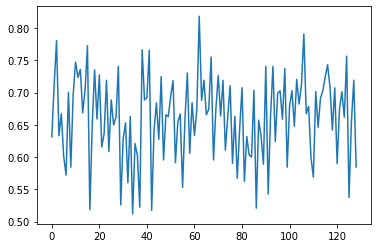

In [43]:
plt.plot(X_train_paa[0])

## DT

In [59]:
param_grid = {'criterion': ['gini'],
              'max_depth': [None], #+ [4, 8, 6], #[None] + list(range(5, 15 +1, 3))
              'min_samples_split': range(2, 100 +2, 10),
              'min_samples_leaf': range(2, 100 +2, 10), #100, 140+1, 20
              'class_weight': [None, 'balanced'] #non conviene
             }

clf = DecisionTreeClassifier()


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train_paa, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   36.2s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   44.8s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini'], 'max_depth': [None],
                         'min_samples_leaf': range(2, 102, 10),
                         'min_samples_split': range(2, 102, 10)},
             scoring='accuracy', verbose=10)

In [60]:
report(grid_search.cv_results_, n_top=10) #sbil = .715 {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 140, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.325 (std: 0.001)
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 82, 'min_samples_split': 2}

Model with rank: 1
Mean validation score: 0.325 (std: 0.001)
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 82, 'min_samples_split': 42}

Model with rank: 1
Mean validation score: 0.325 (std: 0.001)
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 82, 'min_samples_split': 52}

Model with rank: 1
Mean validation score: 0.325 (std: 0.001)
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 82, 'min_samples_split': 72}

Model with rank: 1
Mean validation score: 0.325 (std: 0.001)
Parameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 82, 'min_samples_split': 92}

Model with rank: 6
Mean validation score: 0.325 (std: 0.001)
Parameters

In [42]:
clf = DecisionTreeClassifier(max_depth=None, min_samples_leaf=82, min_samples_split=2, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.11436116189315458
F1-score [0.10630408 0.06871166 0.10884354 0.25362708 0.08394161 0.05980066
 0.06325301 0.13365155 0.05418139 0.06974359]
              precision    recall  f1-score   support

           0       0.07      0.21      0.11       203
           1       0.04      0.23      0.07       121
           2       0.08      0.17      0.11       232
           3       0.53      0.17      0.25      1415
           4       0.27      0.05      0.08       925
           5       0.24      0.03      0.06      1054
           6       0.05      0.08      0.06       277
           7       0.12      0.16      0.13       353
           8       0.04      0.11      0.05       207
           9       0.04      0.25      0.07       136

    accuracy                           0.11      4923
   macro avg       0.15      0.15      0.10      4923
weighted avg       0.28      0.11      0.13      4923



## KNN pyts

In [15]:
from pyts.classification import KNeighborsClassifier


param_grid = {'n_neighbors': range(1, 201, 10), #[None] + list(range(5, 15 +1, 3))
              'metric': ["dtw_sakoechiba", "dtw_itakura"],
             }

clf = KNeighborsClassifier(n_jobs=-1)


grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, verbose=10, scoring='accuracy', cv=3)
grid_search.fit(X_train_paa[:2000], y_train[:2000])

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done  86 out of 120 | elapsed: 18.7min remaining:  7.4min
[Parallel(n_jobs=-1)]: Done  99 out of 120 | elapsed: 22.5min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done 112 out of 120 | elapsed: 23.2min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 23.4min finished


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'metric': ['dtw_sakoechiba', 'dtw_itakura'],
                         'n_neighbors': range(1, 201, 10)},
             scoring='accuracy', verbose=10)

In [16]:
report(grid_search.cv_results_, n_top=10)

Model with rank: 1
Mean validation score: 0.367 (std: 0.007)
Parameters: {'metric': 'dtw_sakoechiba', 'n_neighbors': 21}

Model with rank: 2
Mean validation score: 0.365 (std: 0.015)
Parameters: {'metric': 'dtw_sakoechiba', 'n_neighbors': 11}

Model with rank: 3
Mean validation score: 0.363 (std: 0.004)
Parameters: {'metric': 'dtw_itakura', 'n_neighbors': 11}

Model with rank: 4
Mean validation score: 0.361 (std: 0.007)
Parameters: {'metric': 'dtw_sakoechiba', 'n_neighbors': 41}

Model with rank: 5
Mean validation score: 0.361 (std: 0.007)
Parameters: {'metric': 'dtw_itakura', 'n_neighbors': 21}

Model with rank: 6
Mean validation score: 0.360 (std: 0.006)
Parameters: {'metric': 'dtw_sakoechiba', 'n_neighbors': 31}

Model with rank: 7
Mean validation score: 0.355 (std: 0.010)
Parameters: {'metric': 'dtw_itakura', 'n_neighbors': 31}

Model with rank: 8
Mean validation score: 0.354 (std: 0.006)
Parameters: {'metric': 'dtw_itakura', 'n_neighbors': 41}

Model with rank: 9
Mean validation s

In [30]:
from pyts.classification import KNeighborsClassifier

clf = KNeighborsClassifier(metric='dtw_sakoechiba', n_jobs=-1, n_neighbors=21)
clf.fit(X_train_paa[:2000], y_train[:2000])

y_pred = clf.predict(X_test_paa)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

NameError: name 'X_train_paa' is not defined

# Provo un ensamble con le distanze

In [22]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=1000, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced',
                             verbose=3,
                             n_jobs=-1,
                             oob_score=True)


clf.fit(X_train2, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000

building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000

building tree 12 of 1000
building tree 13 of 1000building tree 14 of 1000

building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000building tree 20 of 1000

building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000building tree 33 of 1000
building tree 34 of 1000building tree 35 of 1000


building tree 36 of 1000building tree 37 of 1000

building tree 38 of 1000
building tree 39 of 1000building tree 40 of 1000building tr

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    2.2s


building tree 114 of 1000
building tree 115 of 1000
building tree 116 of 1000
building tree 117 of 1000
building tree 118 of 1000
building tree 119 of 1000
building tree 120 of 1000
building tree 121 of 1000
building tree 122 of 1000
building tree 123 of 1000
building tree 124 of 1000
building tree 125 of 1000
building tree 126 of 1000
building tree 127 of 1000
building tree 128 of 1000
building tree 129 of 1000
building tree 130 of 1000
building tree 131 of 1000
building tree 132 of 1000
building tree 133 of 1000
building tree 134 of 1000
building tree 135 of 1000
building tree 136 of 1000
building tree 137 of 1000
building tree 138 of 1000
building tree 139 of 1000
building tree 140 of 1000
building tree 141 of 1000
building tree 142 of 1000
building tree 143 of 1000
building tree 144 of 1000
building tree 145 of 1000
building tree 146 of 1000
building tree 147 of 1000
building tree 148 of 1000
building tree 149 of 1000building tree 150 of 1000

building tree 151 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    6.0s


building tree 264 of 1000
building tree 265 of 1000
building tree 266 of 1000
building tree 267 of 1000
building tree 268 of 1000
building tree 269 of 1000
building tree 270 of 1000
building tree 271 of 1000
building tree 272 of 1000
building tree 273 of 1000
building tree 274 of 1000
building tree 275 of 1000
building tree 276 of 1000
building tree 277 of 1000
building tree 278 of 1000
building tree 279 of 1000
building tree 280 of 1000
building tree 281 of 1000
building tree 282 of 1000
building tree 283 of 1000
building tree 284 of 1000
building tree 285 of 1000
building tree 286 of 1000
building tree 287 of 1000
building tree 288 of 1000
building tree 289 of 1000
building tree 290 of 1000
building tree 291 of 1000
building tree 292 of 1000
building tree 293 of 1000
building tree 294 of 1000
building tree 295 of 1000
building tree 296 of 1000
building tree 297 of 1000
building tree 298 of 1000
building tree 299 of 1000
building tree 300 of 1000
building tree 301 of 1000
building tre

[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   11.2s



building tree 498 of 1000
building tree 499 of 1000
building tree 500 of 1000
building tree 501 of 1000
building tree 502 of 1000
building tree 503 of 1000
building tree 504 of 1000
building tree 505 of 1000
building tree 506 of 1000
building tree 507 of 1000
building tree 508 of 1000
building tree 509 of 1000
building tree 510 of 1000
building tree 511 of 1000
building tree 512 of 1000
building tree 513 of 1000
building tree 514 of 1000
building tree 515 of 1000
building tree 516 of 1000
building tree 517 of 1000
building tree 518 of 1000
building tree 519 of 1000
building tree 520 of 1000
building tree 521 of 1000
building tree 522 of 1000
building tree 523 of 1000
building tree 524 of 1000
building tree 525 of 1000
building tree 526 of 1000
building tree 527 of 1000
building tree 528 of 1000
building tree 529 of 1000
building tree 530 of 1000
building tree 531 of 1000
building tree 532 of 1000
building tree 533 of 1000
building tree 534 of 1000
building tree 535 of 1000
building tr

[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   18.0s



building tree 779 of 1000
building tree 780 of 1000
building tree 781 of 1000
building tree 782 of 1000
building tree 783 of 1000
building tree 784 of 1000
building tree 785 of 1000
building tree 786 of 1000
building tree 787 of 1000
building tree 788 of 1000
building tree 789 of 1000
building tree 790 of 1000building tree 791 of 1000

building tree 792 of 1000
building tree 793 of 1000
building tree 794 of 1000
building tree 795 of 1000
building tree 796 of 1000
building tree 797 of 1000
building tree 798 of 1000
building tree 799 of 1000
building tree 800 of 1000
building tree 801 of 1000
building tree 802 of 1000
building tree 803 of 1000
building tree 804 of 1000
building tree 805 of 1000
building tree 806 of 1000
building tree 807 of 1000
building tree 808 of 1000
building tree 809 of 1000
building tree 810 of 1000
building tree 811 of 1000
building tree 812 of 1000
building tree 813 of 1000
building tree 814 of 1000
building tree 815 of 1000
building tree 816 of 1000building tre

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   23.9s finished


RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=0, verbose=3)

In [23]:
# 1000 ----------> 42
# 5000 ----------> 43

y_pred = clf.predict(X_test2)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 240 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 464 tasks      | elapsed:    0.1s


Accuracy 0.43103798496851514
F1-score [0.25830258 0.3248731  0.08301887 0.56973645 0.36938032 0.45700042
 0.23734729 0.40161725 0.08658009 0.01459854]
              precision    recall  f1-score   support

           0       0.51      0.17      0.26       203
           1       0.42      0.26      0.32       121
           2       0.33      0.05      0.08       232
           3       0.49      0.68      0.57      1415
           4       0.42      0.33      0.37       925
           5       0.41      0.52      0.46      1054
           6       0.23      0.25      0.24       277
           7       0.38      0.42      0.40       353
           8       0.42      0.05      0.09       207
           9       1.00      0.01      0.01       136

    accuracy                           0.43      4923
   macro avg       0.46      0.27      0.28      4923
weighted avg       0.44      0.43      0.40      4923



[Parallel(n_jobs=24)]: Done 752 tasks      | elapsed:    0.1s
[Parallel(n_jobs=24)]: Done 1000 out of 1000 | elapsed:    0.2s finished


In [28]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, 
                             criterion='gini', 
                             max_depth=None, 
                             min_samples_split=10, 
                             min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, 
                             max_features='auto', 
                             random_state=0,
                             class_weight = 'balanced',
                             verbose=3,
                             n_jobs=-1,
                             oob_score=True)


clf.fit(X_train3, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 24 concurrent workers.


building tree 1 of 200building tree 2 of 200building tree 3 of 200
building tree 4 of 200

building tree 5 of 200

building tree 6 of 200building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200

building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200building tree 17 of 200

building tree 18 of 200
building tree 19 of 200building tree 20 of 200

building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200building tree 29 of 200

building tree 30 of 200building tree 31 of 200

building tree 32 of 200
building tree 33 of 200building tree 34 of 200

building tree 35 of 200building tree 36 of 200building tree 37 of 200
building tree 38 of 200building tree 39 of 200building tree 40 of 200




building tree 41 of 200building tree 42 of 200
bu

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.9s


building tree 121 of 200
building tree 122 of 200
building tree 123 of 200
building tree 124 of 200
building tree 125 of 200building tree 126 of 200

building tree 127 of 200
building tree 128 of 200
building tree 129 of 200
building tree 130 of 200building tree 131 of 200

building tree 132 of 200building tree 133 of 200

building tree 134 of 200building tree 135 of 200building tree 136 of 200building tree 137 of 200building tree 138 of 200building tree 139 of 200




building tree 140 of 200building tree 141 of 200building tree 142 of 200

building tree 143 of 200


building tree 144 of 200
building tree 145 of 200
building tree 146 of 200
building tree 147 of 200
building tree 148 of 200
building tree 149 of 200
building tree 150 of 200
building tree 151 of 200
building tree 152 of 200
building tree 153 of 200building tree 154 of 200
building tree 155 of 200

building tree 156 of 200building tree 157 of 200

building tree 158 of 200
building tree 159 of 200building tree 160 of 200bu

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    2.1s finished


RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=0, verbose=3)

In [29]:
y_pred = clf.predict(X_test3)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.32317692463944747
F1-score [0.17633411 0.03571429 0.20936639 0.48200313 0.33333333 0.32750397
 0.09108159 0.1959799  0.06472492 0.01      ]
              precision    recall  f1-score   support

           0       0.17      0.19      0.18       203
           1       0.04      0.03      0.04       121
           2       0.29      0.16      0.21       232
           3       0.43      0.54      0.48      1415
           4       0.32      0.34      0.33       925
           5       0.37      0.29      0.33      1054
           6       0.10      0.09      0.09       277
           7       0.18      0.22      0.20       353
           8       0.10      0.05      0.06       207
           9       0.02      0.01      0.01       136

    accuracy                           0.32      4923
   macro avg       0.20      0.19      0.19      4923
weighted avg       0.31      0.32      0.31      4923



[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done  80 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 200 out of 200 | elapsed:    0.0s finished


# Da Qui è OPZIONALE

## CNN Classifier


In [121]:
# one hot encoder --> devo avere un vettore
import tensorflow as tf

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [122]:
y_train.shape

(44306, 10)

In [133]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.layers import Conv1D, Activation, Conv1D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

def build_simple_cnn(n_timesteps, n_outputs):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, 1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='softmax')) #sigmoid
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_train_cnn, y_train, test_size=0.2, stratify=y_train)

n_timesteps, n_outputs, n_features = X_train_cnn.shape[1], len(np.unique(y_train_cnn)), 1 
n_outputs = 10
print("TIMESTEPS: ", n_timesteps)
print("N. LABELS: ", n_outputs)

cnn = build_simple_cnn(n_timesteps, n_outputs)

cnn.summary()

TIMESTEPS:  1292
N. LABELS:  10
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 1285, 16)          144       
_________________________________________________________________
batch_normalization_12 (Batc (None, 1285, 16)          64        
_________________________________________________________________
activation_12 (Activation)   (None, 1285, 16)          0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 1285, 16)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1281, 32)          2592      
_________________________________________________________________
batch_normalization_13 (Batc (None, 1281, 32)          128       
_________________________________________________________________
activation_13 (Activat

In [135]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001)
mc = ModelCheckpoint('best_model_cnn.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=20)

callbacks = [rlr, mc, es]

batch_size = 128
mini_batch_size = int(min(X_train_cnn.shape[0]/10, batch_size))


history_cnn = cnn.fit(X_train_cnn, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history



Epoch 1/1000
277/277 [==============================] - 13s 47ms/step - loss: 1.5322 - accuracy: 0.4805 - val_loss: 1.6447 - val_accuracy: 0.4446
Epoch 2/1000
277/277 [==============================] - 14s 50ms/step - loss: 1.5283 - accuracy: 0.4834 - val_loss: 1.6361 - val_accuracy: 0.4590
Epoch 3/1000
277/277 [==============================] - 14s 50ms/step - loss: 1.5273 - accuracy: 0.4825 - val_loss: 1.5688 - val_accuracy: 0.4742
Epoch 4/1000
277/277 [==============================] - 12s 44ms/step - loss: 1.5258 - accuracy: 0.4796 - val_loss: 1.6023 - val_accuracy: 0.4619
Epoch 5/1000
277/277 [==============================] - 11s 41ms/step - loss: 1.5234 - accuracy: 0.4825 - val_loss: 1.5547 - val_accuracy: 0.4808
Epoch 6/1000
277/277 [==============================] - 11s 41ms/step - loss: 1.5223 - accuracy: 0.4823 - val_loss: 1.6542 - val_accuracy: 0.4237
Epoch 7/1000
277/277 [==============================] - 11s 41ms/step - loss: 1.5219 - accuracy: 0.4847 - val_loss: 1.6252 -

In [143]:
y_pred = np.argmax(cnn.predict(X_test_cnn), axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.29      0.34      0.31       203
           1       0.08      0.91      0.15       121
           2       0.24      0.08      0.12       232
           3       0.69      0.55      0.61      1415
           4       0.48      0.36      0.41       925
           5       0.41      0.42      0.41      1054
           6       0.28      0.02      0.03       277
           7       0.59      0.21      0.31       353
           8       0.00      0.00      0.00       207
           9       0.17      0.26      0.21       136

    accuracy                           0.38      4923
   macro avg       0.32      0.31      0.26      4923
weighted avg       0.46      0.38      0.39      4923



# LSTM Classifier

In [148]:
from keras.layers import LSTM

def build_lstm(n_timesteps, n_outputs):
    model = Sequential()
    model.add(LSTM(256*3, input_shape=(n_timesteps, 1))) #256
    model.add(Dropout(0.2))
    model.add(Dense(64*2, activation='relu')) #64
    model.add(Dropout(0.1))
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

lstm = build_lstm(n_timesteps, n_outputs)

lstm.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 768)               2365440   
_________________________________________________________________
dropout_23 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               98432     
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1290      
Total params: 2,465,162
Trainable params: 2,465,162
Non-trainable params: 0
_________________________________________________________________


In [149]:
history_lstm = cnn.fit(X_train_cnn, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                       validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/1000
277/277 [==============================] - 13s 45ms/step - loss: 1.4722 - accuracy: 0.5030 - val_loss: 1.6820 - val_accuracy: 0.4367
Epoch 2/1000
277/277 [==============================] - 12s 45ms/step - loss: 1.4716 - accuracy: 0.5012 - val_loss: 1.5800 - val_accuracy: 0.4753
Epoch 3/1000
277/277 [==============================] - 14s 52ms/step - loss: 1.4722 - accuracy: 0.5041 - val_loss: 1.6201 - val_accuracy: 0.4545
Epoch 4/1000
277/277 [==============================] - 14s 50ms/step - loss: 1.4711 - accuracy: 0.5044 - val_loss: 1.6445 - val_accuracy: 0.4534
Epoch 5/1000
277/277 [==============================] - 13s 48ms/step - loss: 1.4725 - accuracy: 0.5032 - val_loss: 1.5437 - val_accuracy: 0.4839
Epoch 6/1000
277/277 [==============================] - 12s 45ms/step - loss: 1.4699 - accuracy: 0.5017 - val_loss: 1.7163 - val_accuracy: 0.4255
Epoch 7/1000
277/277 [==============================] - 14s 49ms/step - loss: 1.4704 - accuracy: 0.5036 - val_loss: 1.6285 -

KeyboardInterrupt: 

In [151]:
y_pred = np.argmax(lstm.predict(X_test_cnn), axis=1)

print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.02      0.01      0.01       203
           1       0.00      0.00      0.00       121
           2       0.00      0.00      0.00       232
           3       0.33      0.00      0.00      1415
           4       0.00      0.00      0.00       925
           5       0.00      0.00      0.00      1054
           6       0.00      0.00      0.00       277
           7       0.00      0.00      0.00       353
           8       0.00      0.00      0.00       207
           9       0.03      1.00      0.06       136

    accuracy                           0.03      4923
   macro avg       0.04      0.10      0.01      4923
weighted avg       0.10      0.03      0.00      4923



C:\Users\cri98\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
lstm.predict(X_test_cnn)

array([[0.49535623, 0.49195835, 0.48311213, ..., 0.5004765 , 0.5083701 ,
        0.49009842],
       [0.49593696, 0.49316415, 0.48589578, ..., 0.5005225 , 0.5070969 ,
        0.4916768 ],
       [0.49543884, 0.49166885, 0.48199564, ..., 0.50033695, 0.5087665 ,
        0.48952162],
       ...,
       [0.49919757, 0.4985856 , 0.49711412, ..., 0.50015   , 0.5014399 ,
        0.49826646],
       [0.49772415, 0.49644864, 0.4925888 , ..., 0.5002229 , 0.5037957 ,
        0.4955803 ],
       [0.49954277, 0.49872023, 0.4967232 , ..., 0.49986628, 0.50142694,
        0.498151  ]], dtype=float32)

# Multivariate Time Series Classifiers

In [152]:
from pyts.datasets import load_basic_motions

from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score


In [155]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import TimeDistributed
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, Conv2D, MaxPool2D, Flatten, Dropout, LeakyReLU, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint



def build_lstm2(n_timesteps, n_outputs, n_features):
    model = Sequential()
    model.add(LSTM(4, input_shape=(n_timesteps, n_features), return_sequences=True, 
                        kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    
    #1
    for _ in range(2):
        model.add(LSTM(4, kernel_initializer='TruncatedNormal', return_sequences=True))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.04))   

    #2
    model.add(LSTM(32, kernel_initializer='TruncatedNormal', return_sequences=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
    
    #3
    for _ in range(2):
        model.add(Dense(256, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))
    #4
    for _ in range(1):
        model.add(Dense(64, kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.7))

    #5
    model.add(Dense(32, kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


lstm2 = build_lstm2(n_timesteps, n_outputs, n_features)

lstm2.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1292, 4)           96        
_________________________________________________________________
batch_normalization_23 (Batc (None, 1292, 4)           16        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1292, 4)           0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 1292, 4)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 1292, 4)           144       
_________________________________________________________________
batch_normalization_24 (Batc (None, 1292, 4)           16        
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 1292, 4)         

In [156]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [rlr, mc, es]

batch_size = 1024
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

history_lstm2 = lstm2.fit(X_train_cnn, y_train_cnn, epochs=50, batch_size=mini_batch_size, callbacks=callbacks,
                          validation_data=(X_val_cnn, y_val_cnn)).history

Epoch 1/50
35/35 [==============================] - 19s 385ms/step - loss: 2.6968 - accuracy: 0.0846 - val_loss: 2.2338 - val_accuracy: 0.2873
Epoch 2/50
35/35 [==============================] - 13s 367ms/step - loss: 2.2941 - accuracy: 0.2029 - val_loss: 2.1432 - val_accuracy: 0.2873
Epoch 3/50
35/35 [==============================] - 12s 355ms/step - loss: 2.1596 - accuracy: 0.2843 - val_loss: 2.0699 - val_accuracy: 0.2873
Epoch 4/50
35/35 [==============================] - 13s 381ms/step - loss: 2.1183 - accuracy: 0.2851 - val_loss: 2.0202 - val_accuracy: 0.2873
Epoch 5/50
35/35 [==============================] - 11s 326ms/step - loss: 2.0583 - accuracy: 0.2910 - val_loss: 1.9886 - val_accuracy: 0.2873
Epoch 6/50
35/35 [==============================] - 12s 332ms/step - loss: 2.0224 - accuracy: 0.3013 - val_loss: 1.9700 - val_accuracy: 0.2873
Epoch 7/50
35/35 [==============================] - 13s 379ms/step - loss: 2.0105 - accuracy: 0.2988 - val_loss: 1.9612 - val_accuracy: 0.2873

In [ ]:
y_pred = np.argmax(lstm2.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
X_train_cnn2 = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], X_train_cnn.shape[2], 1)
X_val_cnn2 = X_val_cnn.reshape(X_val_cnn.shape[0], X_val_cnn.shape[1], X_val_cnn.shape[2], 1)
X_test_cnn2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

X_train_cnn2.shape

In [ ]:
def build_cnn2(n_timesteps, n_features, n_outputs):
    input_shape = (n_timesteps, n_features, 1)

    model = Sequential()
    
    ks1_first = 3
    ks1_second = 3
    
    ks2_first = 4
    ks2_second = 4
    
    model.add(Conv2D(filters=(3), 
                     kernel_size=(ks1_first, ks1_second),
                     input_shape=input_shape, 
                     padding='same',
                     kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.02))
    
    for _ in range(2):
        model.add(Conv2D(filters=(4), 
                     kernel_size= (ks2_first, ks2_second), 
                         padding='same',
                     kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.2))  
    
    model.add(Flatten())
    
    for _ in range(4):
        model.add(Dense(64 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.4))
    
    for _ in range(3):
        model.add(Dense(128 , kernel_initializer='TruncatedNormal'))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Dropout(0.3))
  
    model.add(Dense(1024 , kernel_initializer='TruncatedNormal'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.7))
        
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


cnn2 = build_cnn2(n_timesteps, n_features, n_outputs)

cnn2.summary()

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [rlr, mc, es]

batch_size = 64
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))

In [ ]:
history_cnn2 = cnn2.fit(X_train_cnn2, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn2, y_val_cnn)).history

In [ ]:
y_pred = np.argmax(cnn2.predict(X_test_cnn2), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

In [ ]:
def build_cnn3(n_timesteps, n_outputs, n_features):
    model = Sequential()
    
    model.add(Conv1D(filters=16, kernel_size=8, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dropout(0.3))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(n_outputs, activation='sigmoid'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


cnn3 = build_cnn3(n_timesteps, n_outputs, n_features)

cnn3.summary()

In [ ]:
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.0001)
mc = ModelCheckpoint('best_model_lstm2.h5', monitor='val_loss', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=10)

callbacks = [rlr, mc, es]

batch_size = 32
mini_batch_size = int(min(X_train.shape[0]/10, batch_size))


history_cnn3 = cnn3.fit(X_train_cnn, y_train_cnn, epochs=1000, batch_size=mini_batch_size, callbacks=callbacks,
                      validation_data=(X_val_cnn, y_val_cnn)).history

In [ ]:
y_pred = np.argmax(cnn3.predict(X_test), axis=1)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))